In [1]:
# conda env create -n obb --file https://raw.githubusercontent.com/OpenBB-finance/OpenBBTerminal/main/build/conda/conda-3-9-env.yaml

In [2]:
# import sys
# ! {sys.executable} -m pip install statsmodels

In [3]:
import numpy as np
import pandas as pd
from openbb import obb
from statsmodels.regression.linear_model import OLS

In [4]:
mag_seven = "GOOGL AMZN AAPL META MSFT NVDA TSLA".split(" ")
assert len(mag_seven) == 7

In [5]:
df = obb.equity.price.historical(mag_seven, provider="yfinance").to_df().set_index('symbol', append=True)
df.head()

open    high     low   close    volume  dividends  \
date       symbol                                                        
2023-03-02 AAPL    144.38  146.71  143.90  145.91  52238100        0.0   
           AMZN     91.41   92.23   90.39   92.13  55509400        0.0   
           GOOGL    89.66   92.28   89.59   92.00  32204400        0.0   
           META    172.38  175.01  171.43  174.53  17352000        0.0   
           MSFT    246.55  251.40  245.61  251.11  24808200        0.0   

                   stock_splits  
date       symbol                
2023-03-02 AAPL             0.0  
           AMZN             0.0  
           GOOGL            0.0  
           META             0.0  
           MSFT             0.0

### The question: what's the Friday close -> Monday open return of the magnificent seven over the last 6 months?

In [6]:
df['previous_close'] = df.close.unstack().shift().stack()

In [7]:
# for Mondays, what is open - previous close
rets = df[df.index.get_level_values(0).dayofweek == 0].open / df[df.index.get_level_values(0).dayofweek == 0].previous_close - 1
rets = rets['2023-10-01':] # last 6 months

In [8]:
# average return for equal weighted portfolio holding over weekend
rets.mean()

-0.000723077616955763

In [9]:
# annualized 
rets.mean() * (52 / rets.index.get_level_values(0).nunique())

-0.0020888908934277597

In [10]:
rets.mean() / (rets.std() ** 0.5)

-0.007576854404191028

<Axes: title={'center': 'cumulative return of weekend hold, equal weighted mag7'}, xlabel='date'>

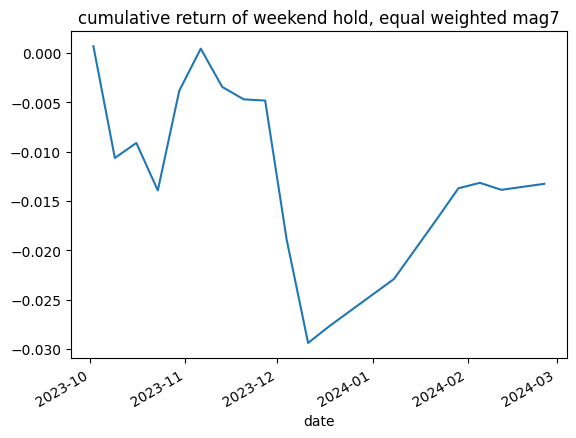

In [11]:
((rets.unstack().mean(1) + 1).cumprod() - 1).plot(title='cumulative return of weekend hold, equal weighted mag7')

#### C! -> holding over weekend is very close to 0 return, on average

### The question: is close->open different on Monday open versus other days of week? 

In [12]:
df['close_open_ret'] = df.open / df.previous_close - 1
# equal weighted portfolio
lm_data = df['2023-10-01':].close_open_ret.unstack().mean(1).to_frame('close_open_ret').assign(is_monday=lambda fr: (fr.index.get_level_values(0).dayofweek == 0) * 1)

In [13]:
OLS(
    lm_data.close_open_ret,
    lm_data[['is_monday']].assign(intercept=lambda _: 1),
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         close_open_ret   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.5337
Date:                Sat, 02 Mar 2024   Prob (F-statistic):              0.467
Time:                        15:25:41   Log-Likelihood:                 359.48
No. Observations:                 105   AIC:                            -715.0
Df Residuals:                     103   BIC:                            -709.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
is_monday     -0.0015      0.002     -0.731      0.467      -0.006       0.003
intercept      0.0008      0.001      0.917      0.361      -0.001       0.002
==============================================================================
Omnibus:                       11.567   Durbin-Watson:                   1.827
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               22.039
Skew:                           0.388   Prob(JB):                     1.64e-05
Kurtosis:                       5.106   Cond. No.                         2.74
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### C! -> holding over weekend seems no different than holding over weeknight